## Analyzing the Relationship Between EV Charging Infrastructure and Adoption to Forecast Future Market Growth

Group 8: Anduo Wang, Claudine Maura Handali, Kalkidan  Berhe Gebrekirstos, Nabila Afifah Qotrunnada, Stephanie Patricia Anshell


In [1]:
import pandas as pd
import re
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

#### Vehicle registration


In [2]:
url_2023 = "https://afdc.energy.gov/vehicle-registration?year=2023"
tables = pd.read_html(url_2023)
df_2023 = tables[0] 

url_2022 = "https://afdc.energy.gov/vehicle-registration?year=2022"
tables_2022 = pd.read_html(url_2022)
df_2022 = tables_2022[0]

url_2021 = "https://afdc.energy.gov/vehicle-registration?year=2021"
tables_2021 = pd.read_html(url_2021)
df_2021 = tables_2021[0]

url_2020 = "https://afdc.energy.gov/vehicle-registration?year=2020"
tables_2020 = pd.read_html(url_2020)
df_2020 = tables_2020[0] 

url_2019 = "https://afdc.energy.gov/vehicle-registration?year=2019"
tables_2019 = pd.read_html(url_2019)
df_2019 = tables[0] 

url_2018 = "https://afdc.energy.gov/vehicle-registration?year=2018"
tables_2018 = pd.read_html(url_2018)
df_2018 = tables[0] 

url_2017 = "https://afdc.energy.gov/vehicle-registration?year=2017"
tables = pd.read_html(url_2017)
df_2017 = tables[0] 

url_2016= "https://afdc.energy.gov/vehicle-registration?year=2016"
tables = pd.read_html(url_2016)
df_2016 = tables[0] 

In [3]:
registration_2023 = df_2023
registration_2022 = df_2022
registration_2021 = df_2021
registration_2020 = df_2020
registration_2019 = df_2019
registration_2018 = df_2018
registration_2017 = df_2017
registration_2016 = df_2016


# Combine all years 2016-2023
all_registrations_full = pd.concat([
    registration_2016, registration_2017, registration_2018, registration_2019,
    registration_2020, registration_2021, registration_2022, registration_2023
], axis=0)

# Add Year column
all_registrations_full['Year'] = (
    [2016]*len(registration_2016) +
    [2017]*len(registration_2017) +
    [2018]*len(registration_2018) +
    [2019]*len(registration_2019) +
    [2020]*len(registration_2020) +
    [2021]*len(registration_2021) +
    [2022]*len(registration_2022) +
    [2023]*len(registration_2023)
)

all_registrations_full.head()


,State,Electric (EV),Plug-In Hybrid Electric (PHEV),Hybrid Electric (HEV),Biodiesel,Ethanol/Flex (E85),Compressed Natural Gas (CNG),Propane,Hydrogen,Methanol,Gasoline,Diesel,Unknown Fuel,Year
0,Alabama,500,900,29100,0,428300,20100,0,0,0,3777300,126500,53900,2016
1,Alaska,200,200,5000,0,55700,4900,0,0,0,525900,44800,19400,2016
2,Arizona,4700,4400,89600,0,427300,17500,0,0,100,4805000,179500,112800,2016
3,Arkansas,200,500,19100,0,320500,12600,0,0,0,2097800,96800,22200,2016
4,California,141500,116700,966700,0,1322600,80600,0,1300,400,27241000,710400,115500,2016


In [4]:
all_registrations_full.columns

Index(['State', 'Electric (EV)', 'Plug-In Hybrid Electric (PHEV)',
       'Hybrid Electric (HEV)', 'Biodiesel', 'Ethanol/Flex (E85)',
       'Compressed Natural Gas (CNG)', 'Propane', 'Hydrogen', 'Methanol',
       'Gasoline', 'Diesel', 'Unknown Fuel', 'Year'],
      dtype='object')

In [5]:
all_registrations= all_registrations_full.loc[:, ['State', 'Electric (EV)', 'Year']]
all_registrations.columns = ['State', 'Registrations', 'Year']
all_registrations.head()


,State,Registrations,Year
0,Alabama,500,2016
1,Alaska,200,2016
2,Arizona,4700,2016
3,Arkansas,200,2016
4,California,141500,2016


#### Charging ports

In [6]:
# Helper function to extract the second number from Ports column
def extract_second_number(s):
    if pd.isna(s):
        return pd.NA
    s = str(s)
    parts = [p.strip() for p in re.split(r"\||/", s) if p.strip() != '']
    if len(parts) >= 2:
        num = parts[1].replace(',', '')
        try:
            return int(num)
        except Exception:
            return pd.NA
    return pd.NA

# Dictionary to store each year's processed DataFrame
ports_simple = {}

for year in range(2016, 2024):  # 2016–2023
    # Read CSV (no header, treat all as string)
    df = pd.read_csv(f'Datasets/{year}_ports.csv', header=None, dtype=str)

    # Slice rows and columns (adjust indices if needed)
    df = df.iloc[3:107, [0, 4]].rename(columns={0: 'State', 4: 'Ports'})

    # Clean State column
    df['State'] = df['State'].astype(str).str.strip()

    # --- NEW FILTERING LINE ---
    # Removes Empty values AND the literal string 'nan' artifact
    df = df[df['State'].notna() & (df['State'] != '') & (df['State'] != 'nan')]
    # --------------------------

    # Extract Charging_Outlets
    df['Charging_Outlets'] = df['Ports'].apply(extract_second_number)

    # Keep only State + sum of Charging_Outlets
    df_simple = (
        df.dropna(subset=['State'])
          .groupby('State', as_index=False)['Charging_Outlets']
          .sum(min_count=1)
    )

    # Save in dictionary
    ports_simple[year] = df_simple

ports_simple[2016].head()

,State,Charging_Outlets
0,Alabama,227
1,Alaska,5
2,Arizona,988
3,Arkansas,89
4,California,13655


In [7]:
# Concatenate all years into a single DataFrame with a Year column
all_ports = pd.concat(
    [df.assign(Year=year) for year, df in ports_simple.items()],
    axis=0,
    ignore_index=True
)

all_ports.head()


,State,Charging_Outlets,Year
0,Alabama,227,2016
1,Alaska,5,2016
2,Arizona,988,2016
3,Arkansas,89,2016
4,California,13655,2016


#### Population

In [9]:

# Load the CSV
pop_before_2020 = pd.read_csv('Datasets/population_before2020.csv', dtype=str)

# Keep only relevant columns: State + POPESTIMATE2016-2019 + Base2020-2023 if present
columns_to_keep = ['NAME'] + [f'POPESTIMATE{y}' for y in range(2016, 2020)]
# If your file also contains 2020–2023, include them
columns_to_keep += [f'POPESTIMATE{y}' for y in range(2020, 2024) if f'POPESTIMATE{y}' in pop_before_2020 .columns]

pop_before_2020 = pop_before_2020[columns_to_keep]

# Rename columns for consistency
pop_before_2020 = pop_before_2020.rename(columns={
    'NAME': 'State',
    **{f'POPESTIMATE{y}': str(y) for y in range(2016, 2024) if f'POPESTIMATE{y}' in pop_before_2020 .columns}
})

# Reset index
pop_before_2020 = pop_before_2020.reset_index(drop=True)

# Display the head
pop_before_2020.head()


,State,2016,2017,2018,2019
0,United States,322941311,324985539,326687501,328239523
1,Northeast Region,56042330,56059240,56046620,55982803
2,Midwest Region,67987540,68126781,68236628,68329004
3,South Region,122351760,123542189,124569433,125580448
4,West Region,76559681,77257329,77834820,78347268


In [11]:
# Load the CSV
pop_after_2020 = pd.read_csv('Datasets/population_estimate.csv', dtype=str)

# Keep only relevant columns: State + POPESTIMATE2020-2023 + Base2020 if needed
columns_to_keep = ['NAME', 'ESTIMATESBASE2020'] + [f'POPESTIMATE{y}' for y in range(2020, 2024)]
pop_after_2020 = pop_after_2020[columns_to_keep]

# Rename columns for clarity
pop_after_2020 = pop_after_2020.rename(columns={
    'NAME': 'State',
    'ESTIMATESBASE2020': 'Base2020',
    'POPESTIMATE2020': '2020',
    'POPESTIMATE2021': '2021',
    'POPESTIMATE2022': '2022',
    'POPESTIMATE2023': '2023'
})

# Reset index
pop_after_2020 = pop_after_2020.reset_index(drop=True)

# Show the cleaned DataFrame
pop_after_2020.head()


,State,Base2020,2020,2021,2022,2023
0,United States,331515736,331577720,332099760,334017321,336806231
1,Northeast Region,57617706,57431458,57252533,57159597,57398303
2,New England,15122011,15057350,15118145,15175633,15263573
3,Middle Atlantic,42495695,42374108,42134388,41983964,42134730
4,Midwest Region,68998970,68984258,68872831,68903297,69186401


In [12]:
# Merge on State
population_df = pd.merge(
    pop_before_2020, 
    pop_after_2020, 
    on='State', 
    how='outer'  
)
year_columns = [str(y) for y in range(2016, 2024)]
population_df = population_df[['State'] + year_columns]

population_df.head()

,State,2016,2017,2018,2019,2020,2021,2022,2023
0,Alabama,4863525,4874486,4887681,4903185,5033094,5049196,5076181,5117673
1,Alaska,741456,739700,735139,731545,733017,734420,734442,736510
2,Arizona,6941072,7044008,7158024,7278717,7187135,7274078,7377566,7473027
3,Arkansas,2989918,3001345,3009733,3017804,3014546,3026870,3047704,3069463
4,California,39167117,39358497,39461588,39512223,39521958,39142565,39142414,39198693


### Data Analysis
#### Merge data

In [13]:
all_registrations

,State,Registrations,Year
0,Alabama,500,2016
1,Alaska,200,2016
2,Arizona,4700,2016
3,Arkansas,200,2016
4,California,141500,2016
...,...,...,...
47,Washington,152100,2023
48,West Virginia,2800,2023
49,Wisconsin,24900,2023
50,Wyoming,1100,2023


In [14]:
# Per-capita analysis: merge data, compute metrics, run correlations and regressions

# --- Prepare population dataframe (wide -> long) ---
# Expect population_df to have columns like 'State', 2016 -2023
pop = population_df.copy()
pop.columns = pop.columns.map(str)

# If column names are numeric strings, ensure they exist; otherwise try alternatives
years = ['2016','2017','2018','2019','2020','2021','2022','2023']
year_cols = [c for c in pop.columns if str(c) in years]
if not year_cols:
    # try exact keys
    for k in years:
        if k in pop.columns:
            year_cols.append(k)

if 'State' not in pop.columns and 'NAME' in pop.columns:
    pop = pop.rename(columns={'NAME':'State'})

# Melt to long format
pop_long = pop.melt(id_vars=['State'], value_vars=[c for c in years if c in pop.columns],
                    var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)
pop_long['Population'] = pd.to_numeric(pop_long['Population'], errors='coerce')

# --- Clean registrations ---
regs = all_registrations.copy()
# Ensure Year column numeric
if regs['Year'].dtype == object:
    regs['Year'] = regs['Year'].astype(str).str.extract(r"(\d{4})").astype(float).astype('Int64')
else:
    regs['Year'] = regs['Year'].astype(int)

# Clean Registrations numeric
regs['Registrations'] = regs['Registrations'].astype(str).str.replace(r'[^0-9]', '', regex=True)
regs['Registrations'] = pd.to_numeric(regs['Registrations'], errors='coerce')

# --- Clean ports ---
ports = all_ports.copy()
if 'Charging_Outlets' in ports.columns:
    ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')
else:
    # fallback: if Ports exists
    if 'Ports' in ports.columns:
        ports['Charging_Outlets'] = ports['Ports'].astype(str).str.replace(r'[^0-9]', '', regex=True)
        ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')

# Ensure Year numeric
ports['Year'] = ports['Year'].astype(int)

# Standardize State names by stripping whitespace
for df in (ports, regs, pop_long):
    df['State'] = df['State'].astype(str).str.strip()

# --- Merge ---
merged = (
    ports.merge(regs[['State','Year','Registrations']], on=['State','Year'], how='inner')
        .merge(pop_long[['State','Year','Population']], on=['State','Year'], how='inner')
)

# Drop rows with missing key values
merged = merged.dropna(subset=['Charging_Outlets','Registrations','Population']).copy()

# Derived metrics
merged['Outlets_per_100k'] = merged['Charging_Outlets'] / merged['Population'] * 100000
merged['EVs_per_1000'] = merged['Registrations'] / merged['Population'] * 1000
merged['log_Outlets_pc'] = np.log1p(merged['Charging_Outlets'] / merged['Population'])
merged['log_EVs_pc'] = np.log1p(merged['Registrations'] / merged['Population'])

#merged[['State','Year','Charging_Outlets','Registrations','Population']].head()
merged.head()

,State,Charging_Outlets,Year,Registrations,Population,Outlets_per_100k,EVs_per_1000,log_Outlets_pc,log_EVs_pc
0,Alabama,227,2016,500,4863525.0,4.667397,0.102806,0.000047,0.000103
1,Alaska,5,2016,200,741456.0,0.674349,0.269740,0.000007,0.000270
2,Arizona,988,2016,4700,6941072.0,14.234113,0.677129,0.000142,0.000677
3,Arkansas,89,2016,200,2989918.0,2.976670,0.066891,0.000030,0.000067
4,California,13655,2016,141500,39167117.0,34.863429,3.612724,0.000349,0.003606


### How is the adoption and distribution of electric vehicles (EVs) related to the charging stations across the United States?

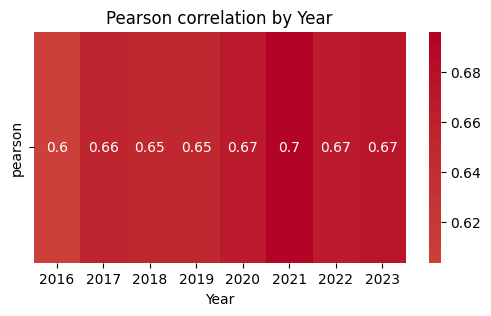

In [15]:
# Year-by-year correlation heatmap between Outlets_per_100k and EVs_per_1000
corrs = merged.groupby('Year').apply(lambda g: pd.Series({
    'pearson': g['Outlets_per_100k'].corr(g['EVs_per_1000'], method='pearson'),
}))

plt.figure(figsize=(6,3))
sns.heatmap(corrs[['pearson']].T, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson correlation by Year')
plt.show()

In [18]:
# Top states by average EVs per 1000 across all years
avg_by_state = merged.groupby('State').agg(
    EVs_per_1000_avg=('EVs_per_1000', 'mean'),
    Outlets_per_100k_avg=('Outlets_per_100k', 'mean')
).reset_index()

ranked_avg = avg_by_state.sort_values('EVs_per_1000_avg', ascending=False)
ranked_avg.head()

,State,EVs_per_1000_avg,Outlets_per_100k_avg
4,California,19.046009,78.682122
47,Washington,11.617095,45.883222
11,Hawaii,11.440993,50.429183
37,Oregon,9.208125,48.160278
5,Colorado,8.749597,51.248132


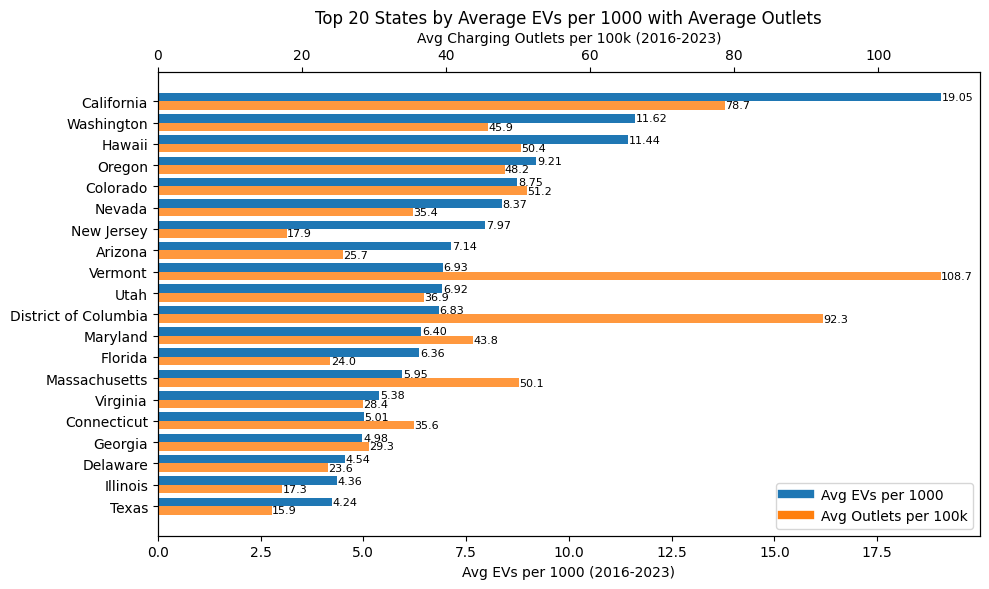

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sort by EVs (descending) for ranking
ranked = avg_by_state.sort_values('EVs_per_1000_avg', ascending=False).reset_index(drop=True)

# Option: limit to top/bottom N for clarity
N = 20
sel = ranked.head(N).copy()   # change to ranked.tail(N) or combine head+tail

y = np.arange(len(sel))
height = 0.4

fig, ax_ev = plt.subplots(figsize=(10, max(6, 0.3*len(sel))))
ax_out = ax_ev.twiny()  # twin x-axis for outlets

# Horizontal bars: EVs on primary x-axis (bottom), outlets on twin x-axis (top)
ev_bars = ax_ev.barh(y - height/2, sel['EVs_per_1000_avg'], height, color='tab:blue', label='Avg EVs per 1000')
out_bars = ax_out.barh(y + height/2, sel['Outlets_per_100k_avg'], height, color='tab:orange', alpha=0.8, label='Avg Outlets per 100k')

# Labels and ticks
ax_ev.set_yticks(y)
ax_ev.set_yticklabels(sel['State'])
ax_ev.invert_yaxis()
ax_ev.set_xlabel('Avg EVs per 1000 (2016-2023)')
ax_out.set_xlabel('Avg Charging Outlets per 100k (2016-2023)')
ax_ev.set_title(f'Top {N} States by Average EVs per 1000 with Average Outlets')

# Annotate numeric values on bars
for rect in ev_bars:
    w = rect.get_width()
    ax_ev.text(w + 0.02, rect.get_y() + rect.get_height()/2, f'{w:.2f}', va='center', fontsize=8)
for rect in out_bars:
    w = rect.get_width()
    ax_out.text(w + 0.02, rect.get_y() + rect.get_height()/2, f'{w:.1f}', va='center', fontsize=8)

# Legend (create custom)
lines = [plt.Line2D([0],[0], color='tab:blue', lw=6), plt.Line2D([0],[0], color='tab:orange', lw=6)]
ax_ev.legend(lines, ['Avg EVs per 1000','Avg Outlets per 100k'], loc='lower right')

plt.tight_layout()
plt.savefig('ranked_avg_paired_bars.png', dpi=200)
plt.show()

The chart shows that while higher EV adoption often coincides with greater charger availability, the relationship is heterogeneous: California stands out with very high EVs per 1,000 and high outlet density, several high‑adoption states (e.g., Washington, Hawaii, Oregon) have only moderate outlet densities relative to California, and a few small or urban jurisdictions (notably Vermont and the District of Columbia) show unusually high outlets per 100k compared with their EV ownership—an effect likely amplified by small population denominators or concentrated public charging. Overall, the pattern suggests some positive alignment between supply and demand but also frequent mismatches (over‑ and under‑provisioning) driven by population scale, urbanization, policy-driven deployments, and timing (infrastructure can lead or follow adoption), so the figure is descriptive and not sufficient on its own to claim causality.

In [20]:
# Growth rates from 2016 to 2023 for EVs per 1000 and Outlets per 100k
start_year = 2016
end_year = 2023
pivot = merged.pivot(index='State', columns='Year', values='EVs_per_1000')
if start_year in pivot.columns and end_year in pivot.columns:
    pivot['EV_growth_pct'] = (pivot[end_year] - pivot[start_year]) / pivot[start_year].replace({0: np.nan}) * 100
else:
    pivot['EV_growth_pct'] = np.nan

pivot_out = merged.pivot(index='State', columns='Year', values='Outlets_per_100k')
if start_year in pivot_out.columns and end_year in pivot_out.columns:
    pivot_out['Outlets_growth_pct'] = (pivot_out[end_year] - pivot_out[start_year]) / pivot_out[start_year].replace({0: np.nan}) * 100
else:
    pivot_out['Outlets_growth_pct'] = np.nan

growth = pd.DataFrame({
    'EV_growth_pct': pivot['EV_growth_pct'],
    'Outlets_growth_pct': pivot_out['Outlets_growth_pct']
}).reset_index()

growth = growth.dropna(subset=['EV_growth_pct', 'Outlets_growth_pct'])
growth.head()

,State,EV_growth_pct,Outlets_growth_pct
0,Alabama,2370.881786,358.842161
1,Alaska,1259.065865,2396.654329
2,Arizona,1674.632688,229.598302
3,Arkansas,3358.001905,811.699822
4,California,787.341175,261.722299


In [21]:
# States where outlets grew faster than EV adoption (potential overbuild) and vice versa
growth_filtered = growth.dropna()
growth_filtered['diff'] = growth_filtered['Outlets_growth_pct'] - growth_filtered['EV_growth_pct']
print('\nStates where Outlets grew faster than EVs (largest positive difference):')
print(growth_filtered.sort_values('diff', ascending=False).head(10).to_string(index=False))
print('\nStates where EVs grew faster than Outlets (largest negative difference):')
print(growth_filtered.sort_values('diff', ascending=True).head(10).to_string(index=False))


States where Outlets grew faster than EVs (largest positive difference):
               State  EV_growth_pct  Outlets_growth_pct        diff
              Alaska    1259.065865         2396.654329 1137.588465
             Georgia     377.955265          211.441523 -166.513742
              Hawaii     503.676320           50.485788 -453.190532
          California     787.341175          261.722299 -525.618876
              Oregon     704.181065          145.576579 -558.604486
           Wisconsin     832.213134          205.799224 -626.413910
          Washington     847.720266          201.537063 -646.183204
             Wyoming     998.398132          299.417503 -698.980630
                Utah    1313.498404          563.336343 -750.162061
District of Columbia    1247.036114          379.443006 -867.593108

States where EVs grew faster than Outlets (largest negative difference):
         State  EV_growth_pct  Outlets_growth_pct         diff
      Michigan    3002.350803          19

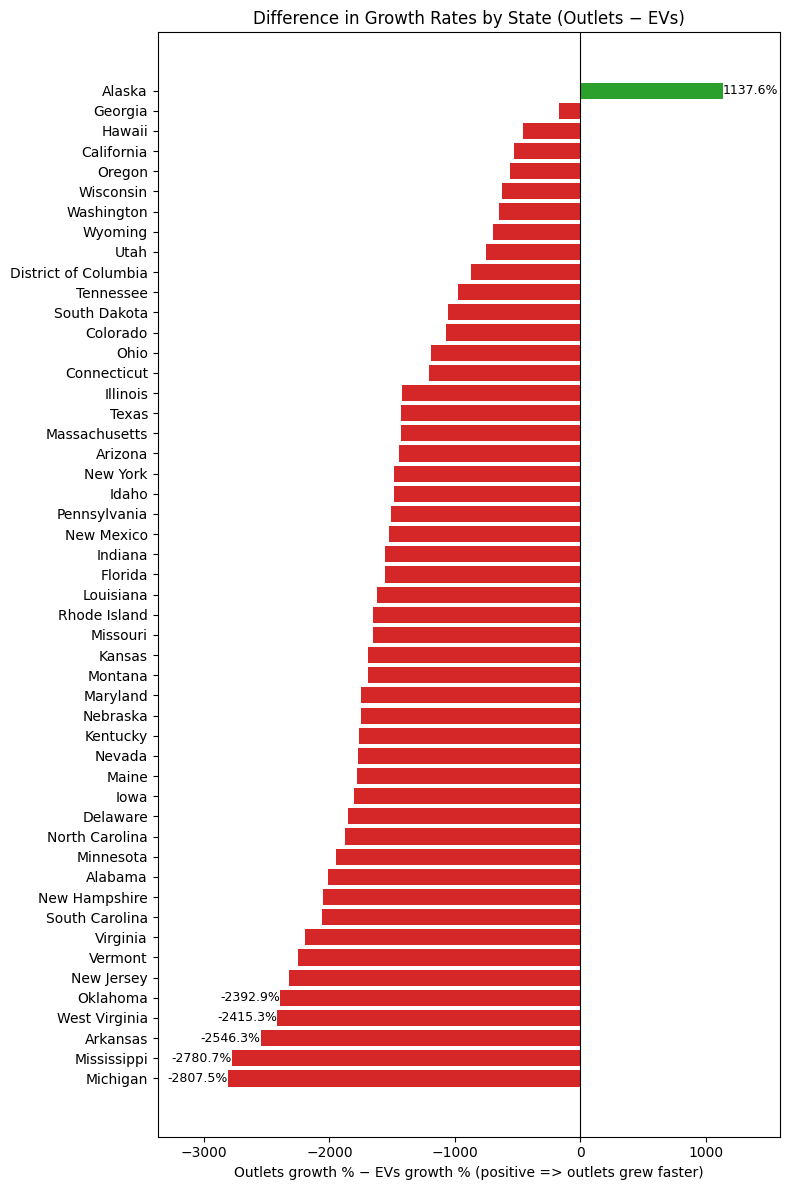

In [22]:
# use growth or growth_filtered if you computed it earlier
df = growth.dropna(subset=['EV_growth_pct','Outlets_growth_pct']).copy()
df['diff'] = df['Outlets_growth_pct'] - df['EV_growth_pct']
df = df.sort_values('diff')  # ascending: large negative (EVs>outlets) at top

# Optional: limit to top/bottom N (uncomment)
# N = 30
# df = pd.concat([df.head(N//2), df.tail(N//2)]).sort_values('diff')

import matplotlib.pyplot as plt
plt.figure(figsize=(8,12))
colors = df['diff'].apply(lambda x: 'tab:green' if x>0 else 'tab:red')
bars = plt.barh(df['State'], df['diff'], color=colors)
plt.axvline(0, color='k', linewidth=0.8)
# Widen left x-axis with proportional padding based on the min value
xmin = df['diff'].min() if not df['diff'].empty else -1
xmax = df['diff'].max() if not df['diff'].empty else 1
# add 10% padding on each side but ensure left side gets more room if negative values dominate
pad_left = abs(xmin) * 0.20 if xmin < 0 else (xmax - xmin) * 0.05
pad_right = abs(xmax) * 0.40 if xmax > 0 else (xmax - xmin) * 0.05
plt.xlim(xmin - pad_left, xmax + pad_right)
plt.xlabel('Outlets growth % − EVs growth % (positive => outlets grew faster)')
plt.title('Difference in Growth Rates by State (Outlets − EVs)')
# annotate top positive and negative for emphasis; shift negative labels further left to avoid overlap
top_pos = df[df['diff']>0].nlargest(5, 'diff')
top_neg = df[df['diff']<0].nsmallest(5, 'diff')
for i, r in pd.concat([top_pos, top_neg]).iterrows():
    offset = 0.5 if r['diff']>0 else -0.8
    ha = 'left' if r['diff']>0 else 'right'
    # slightly larger offset for very negative values
    if r['diff'] < xmin * 0.6:
        offset = -1.2
    plt.text(r['diff'] + offset, r['State'],
            f"{r['diff']:.1f}%", va='center',
            ha=ha, color='black', fontsize=9)
plt.tight_layout()
plt.show()

The diverging bar chart shows the difference between outlets growth % and EVs growth % (2016→2023) by state and reveals a striking imbalance: most states have negative values (red bars), meaning EV adoption grew faster than charging outlets, while only Alaska shows a large positive differences where outlets grew faster than EVs. The magnitude is highly skewed: several states at the extreme negative end (e.g., Michigan, Mississippi, Arkansas) show very large negative percentages, indicating much faster EV growth relative to charger growth, whereas a few small-population or special-case areas show outsized positive percentages. 

EV adoption generally outpaced charger deployment across many states during 2016–2023.
A few outliers suggest either localized over‑deployment or data quirks.
The percentage metrics can be misleading when base-year values are very small (producing huge percent changes).

In [23]:
# === Causal relationships implementation ===
# Goals:
# 1) Test whether charging infrastructure (lagged) predicts EV adoption
# 2) Test reverse direction (lagged EVs -> outlets)

df = merged.copy()

# Ensure Year and State are correct types
df['Year'] = df['Year'].astype(int)
df['State'] = df['State'].astype(str).str.strip()

# Make sure per-capita metrics exist
if 'Outlets_per_100k' not in df.columns:
    df['Outlets_per_100k'] = df['Charging_Outlets'] / df['Population'] * 100000
if 'EVs_per_1000' not in df.columns:
    df['EVs_per_1000'] = df['Registrations'] / df['Population'] * 1000

# Create 1-year lags for both series (grouped by State)
df = df.sort_values(['State','Year']).reset_index(drop=True)
df['Lag1_Outlets_per_100k'] = df.groupby('State')['Outlets_per_100k'].shift(1)
df['Lag1_EVs_per_1000'] = df.groupby('State')['EVs_per_1000'].shift(1)

# Log transforms (stabilize variance)
df['log_EVs_per_1000'] = np.log1p(df['EVs_per_1000'])
df['log_Lag1_Outlets'] = np.log1p(df['Lag1_Outlets_per_100k'])

# Prepare dataset for causal test: keep rows with lag present
causal_df = df.dropna(subset=['Lag1_Outlets_per_100k','Lag1_EVs_per_1000','log_EVs_per_1000']).copy()

print(f"Data prepared for causal tests: {len(causal_df)} observations across {causal_df['State'].nunique()} states.")

# ------------------
# 1) Main specification: Lagged outlets -> current EVs
# ------------------
formula_main = 'log_EVs_per_1000 ~ log_Lag1_Outlets + C(Year) + C(State)'
model_main = smf.ols(formula_main, data=causal_df).fit(cov_type='cluster', cov_kwds={'groups': causal_df['State']})
print('\nMain model (lagged outlets -> EVs)')
print(model_main.summary())

# Save summary
with open('causal_model_main.txt', 'w') as f:
    f.write(str(model_main.summary()))

# ------------------
# 2) Reverse test: Lagged EVs -> current outlets (does past EV adoption predict current outlets?)
# ------------------
# Use Outlets_per_100k (not logged) as dependent, and lagged EVs (log) as predictor
causal_df['log_Lag1_EVs'] = np.log1p(causal_df['Lag1_EVs_per_1000'])
formula_rev = 'Outlets_per_100k ~ log_Lag1_EVs + C(Year) + C(State)'
model_rev = smf.ols(formula_rev, data=causal_df).fit(cov_type='cluster', cov_kwds={'groups': causal_df['State']})
print('\nReverse model (lagged EVs -> outlets)')
print(model_rev.summary())
with open('causal_model_reverse.txt', 'w') as f:
    f.write(str(model_rev.summary()))

# ------------------
# 3) Granger-style panel checks
# ------------------
from statsmodels.tsa.stattools import grangercausalitytests

granger_results = []
maxlag = 2
for state, g in df.groupby('State'):
    g_sorted = g.sort_values('Year')
    if g_sorted['Outlets_per_100k'].notna().sum() >= (maxlag+2) and g_sorted['EVs_per_1000'].notna().sum() >= (maxlag+2):
        ts = g_sorted[['EVs_per_1000','Outlets_per_100k']].dropna()
        if len(ts) >= (maxlag+2):
            try:
                # grangercausalitytests expects a 2-column array where second column causes first
                res = grangercausalitytests(ts[['EVs_per_1000','Outlets_per_100k']], maxlag=maxlag, verbose=False)
                # collect p-values for F-test at each lag
                pvals = {lag: res[lag][0]['ssr_ftest'][1] for lag in res}
                granger_results.append({'State': state, 'n_obs': len(ts), 'pval_lag1': pvals.get(1, np.nan), 'pval_lag2': pvals.get(2, np.nan)})
            except Exception:
                continue

if granger_results:
    gr_res_df = pd.DataFrame(granger_results)
    # Count states where outlets Granger-cause EVs at p<0.05 for any lag
    gr_res_df['significant_any'] = (gr_res_df[['pval_lag1','pval_lag2']].min(axis=1) < 0.05)
    print('\nGranger-style test summary across states:')
    print(gr_res_df[['State','n_obs','pval_lag1','pval_lag2','significant_any']].head(20).to_string(index=False))
    print(f"\nStates with significant Granger-causality (outlets -> EVs) at p<0.05: {gr_res_df['significant_any'].sum()} / {len(gr_res_df)}")
    gr_res_df.to_csv('granger_results_by_state.csv', index=False)
else:
    print('\nNo states had enough data to run Granger-style tests.')


Data prepared for causal tests: 357 observations across 51 states.

Main model (lagged outlets -> EVs)
                            OLS Regression Results                            
Dep. Variable:       log_EVs_per_1000   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     5729.
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           2.67e-70
Time:                        21:39:41   Log-Likelihood:                 240.28
No. Observations:                 357   AIC:                            -364.6
Df Residuals:                     299   BIC:                            -139.6
Df Model:                          57                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
------

In [24]:
# Collinearity diagnostics for the causal specs
# 1) Main: log_EVs_per_1000 ~ log_Lag1_Outlets (+ FE)
# 2) Reverse: Outlets_per_100k ~ log_Lag1_EVs (+ FE)

import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np


df_full = merged.copy()

# Ensure variables exist
for col in ['Outlets_per_100k','EVs_per_1000','Charging_Outlets','Population','Year','State']:
    if col not in df_full.columns:
        print(f'Warning: {col} not found in dataframe (some diagnostics may be skipped)')

# Prepare lagged / logged variables if missing (safe guards)
df_full = df_full.sort_values(['State','Year']).reset_index(drop=True)
if 'Lag1_Outlets_per_100k' not in df_full.columns:
    df_full['Lag1_Outlets_per_100k'] = df_full.groupby('State')['Outlets_per_100k'].shift(1)
if 'Lag1_EVs_per_1000' not in df_full.columns:
    df_full['Lag1_EVs_per_1000'] = df_full.groupby('State')['EVs_per_1000'].shift(1)

# Create log transforms
df_full['log_EVs_per_1000'] = np.log1p(df_full['EVs_per_1000'])
df_full['log_Lag1_Outlets'] = np.log1p(df_full['Lag1_Outlets_per_100k'])
df_full['log_Lag1_EVs'] = np.log1p(df_full['Lag1_EVs_per_1000'])

# Subset for rows with required vars
df_main = df_full.dropna(subset=['log_EVs_per_1000','log_Lag1_Outlets']).copy()
df_rev = df_full.dropna(subset=['Outlets_per_100k','log_Lag1_EVs']).copy()

print(f"Rows for main spec: {len(df_main)}; for reverse spec: {len(df_rev)}")

# Helper: compute VIF for a given DataFrame and list of numeric columns
def compute_vif(df, numeric_cols, add_const=True):
    X = df[numeric_cols].dropna().copy()
    if add_const:
        X = sm.add_constant(X)
    vif = []
    for i in range(X.shape[1]):
        try:
            v = variance_inflation_factor(X.values, i)
        except Exception:
            v = np.nan
        vif.append(v)
    return pd.DataFrame({'variable': X.columns, 'VIF': vif})

# 1) VIF for numeric regressors in main spec (raw)
main_numeric = ['log_Lag1_Outlets']
# include additional numeric controls if present
if 'Gasoline Price (2023 $/gallon)' in df_main.columns:
    main_numeric.append('Gasoline Price (2023 $/gallon)')
if 'Population' in df_main.columns:
    main_numeric.append('Population')

vif_main_raw = compute_vif(df_main, main_numeric)
vif_main_raw.to_csv('vif_main_raw.csv', index=False)

# 2) VIF for numeric regressors in reverse spec (raw)
rev_numeric = ['log_Lag1_EVs']
if 'Population' in df_rev.columns:
    rev_numeric.append('Population')
if 'Gasoline Price (2023 $/gallon)' in df_rev.columns:
    rev_numeric.append('Gasoline Price (2023 $/gallon)')

vif_rev_raw = compute_vif(df_rev, rev_numeric)
vif_rev_raw.to_csv('vif_rev_raw.csv', index=False)

# 3) VIF for within-demeaned (state fixed-effects) variation
# demean by state for each numeric var
def within_demean(df, cols, entity='State'):
    out = df[cols].copy()
    for c in cols:
        out[c + '_within'] = df[c] - df.groupby(entity)[c].transform('mean')
    return out[[c + '_within' for c in cols]]

within_cols_main = [c for c in main_numeric if c in df_main.columns]
if within_cols_main:
    df_within_main = within_demean(df_main, within_cols_main, entity='State')
    df_within_main = pd.concat([df_main[['State','Year']].reset_index(drop=True), df_within_main.reset_index(drop=True)], axis=1)
    vif_main_within = compute_vif(df_within_main, [c + '_within' for c in within_cols_main])
    vif_main_within.to_csv('vif_main_within.csv', index=False)
else:
    vif_main_within = pd.DataFrame()

within_cols_rev = [c for c in rev_numeric if c in df_rev.columns]
if within_cols_rev:
    df_within_rev = within_demean(df_rev, within_cols_rev, entity='State')
    df_within_rev = pd.concat([df_rev[['State','Year']].reset_index(drop=True), df_within_rev.reset_index(drop=True)], axis=1)
    vif_rev_within = compute_vif(df_within_rev, [c + '_within' for c in within_cols_rev])
    vif_rev_within.to_csv('vif_rev_within.csv', index=False)
else:
    vif_rev_within = pd.DataFrame()

# 4) Condition number for design matrix including dummies (warning: may be large)
try:
    # main formula
    formula_main = 'log_EVs_per_1000 ~ log_Lag1_Outlets + C(Year) + C(State)'
    y_main, X_main = patsy.dmatrices(formula_main, data=df_main, return_type='dataframe')
    Xs = X_main.values
    # scale columns
    Xs_scaled = (Xs - Xs.mean(axis=0)) / Xs.std(axis=0)
    u,s,vh = np.linalg.svd(Xs_scaled, full_matrices=False)
    cond_main = float(s[0] / s[-1])
    sv_main = s[:6].tolist()
    cond_main_df = pd.DataFrame({'stat': ['cond_num'] + [f'sv{i+1}' for i in range(len(sv_main))], 'value': [cond_main] + sv_main})
    cond_main_df.to_csv('condition_main.csv', index=False)
except Exception as e:
    print('Could not compute condition number for main:', e)
    cond_main_df = pd.DataFrame()

try:
    formula_rev = 'Outlets_per_100k ~ log_Lag1_EVs + C(Year) + C(State)'
    y_rev, X_rev = patsy.dmatrices(formula_rev, data=df_rev, return_type='dataframe')
    Xr = X_rev.values
    Xr_scaled = (Xr - Xr.mean(axis=0)) / Xr.std(axis=0)
    ur,sr,vhr = np.linalg.svd(Xr_scaled, full_matrices=False)
    cond_rev = float(sr[0] / sr[-1])
    sv_rev = sr[:6].tolist()
    cond_rev_df = pd.DataFrame({'stat': ['cond_num'] + [f'sv{i+1}' for i in range(len(sv_rev))], 'value': [cond_rev] + sv_rev})
    cond_rev_df.to_csv('condition_rev.csv', index=False)
except Exception as e:
    print('Could not compute condition number for reverse:', e)
    cond_rev_df = pd.DataFrame()

# Print concise report
print('\nVIF (main raw):')
print(vif_main_raw.to_string(index=False))
print('\nVIF (main within):')
print(vif_main_within.to_string(index=False) if not vif_main_within.empty else 'N/A')
print('\nVIF (reverse raw):')
print(vif_rev_raw.to_string(index=False))
print('\nVIF (reverse within):')
print(vif_rev_within.to_string(index=False) if not vif_rev_within.empty else 'N/A')
print('\nCondition number (main) saved to condition_main.csv' if not cond_main_df.empty else '\nCondition main: N/A')
print('\nCondition number (reverse) saved to condition_rev.csv' if not cond_rev_df.empty else '\nCondition rev: N/A')

print('\nCollinearity diagnostics saved: vif_main_raw.csv, vif_main_within.csv (if available), vif_rev_raw.csv, vif_rev_within.csv (if available), condition_main.csv, condition_rev.csv')

Rows for main spec: 357; for reverse spec: 357
Could not compute condition number for main: SVD did not converge
Could not compute condition number for reverse: SVD did not converge

VIF (main raw):
        variable       VIF
           const 16.049722
log_Lag1_Outlets  1.013454
      Population  1.013454

VIF (main within):
               variable     VIF
                  const 1.00000
log_Lag1_Outlets_within 1.18357
      Population_within 1.18357

VIF (reverse raw):
    variable      VIF
       const 3.615668
log_Lag1_EVs 1.065333
  Population 1.065333

VIF (reverse within):
           variable     VIF
              const 1.00000
log_Lag1_EVs_within 1.08155
  Population_within 1.08155

Condition main: N/A

Condition rev: N/A

Collinearity diagnostics saved: vif_main_raw.csv, vif_main_within.csv (if available), vif_rev_raw.csv, vif_rev_within.csv (if available), condition_main.csv, condition_rev.csv
